## IMDB Review NLP

--- 

Neste notebook vamos ler um arquivo do tipo **.csv** com cerca de 50.000 reviews de diversos filmes do [IMDB](https://www.imdb.com/) disponíveis no [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) e analisar o sentimento de cada review, baseado em um segundo dataset também disponível no [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp), que comporta uma coleção de frases simples acompanhadas do sentimento classificado como predominante nela (como tristeza, raiva, amor, medo, etc). 

O processo foi dividido em N etapas, sendo elas:

1. *Configuração de Ambiente*
   1. *Higienização de dados*
   2. *Métodos e Variáveis do ambiente*
2. *Leitura do Dataset de Reviews.*
   1. *Limpeza dos Diretórios*
   2. *Criação de arquivos de review*
   3. *Criação de Bag of Words*
3. *Leitura do Dataset de Sentimento.*
4. *Sumário dos dados obtidos após leitura dos Datasets.*
5. ... 

Durante a etapa N iremos mostrar uma análise dos sentimentos encontrados em cada review e falar um pouco sobre...


---

#### Passo 1 - Configuração de Ambiente

In [84]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [85]:
import os
import re
import nltk
import pandas as pds
import seaborn as sns
import matplotlib as mpl
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk import FreqDist, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Processamentos Realizados
---
1. Remoção das tags html e sequência html
2. Remoção dos simbolos e números
3. Tokenização do review
4. Remoção das stopwords
5. Lemmatization dos tokens

In [86]:
# carrega as reviews do imdb para o data frame
data_frame = pds.read_csv('../assets/Reviews/reviews.csv')

# remove as tags <br>, <br /> e a sequencia 'html'
pattern = r'(<br>|<br />|http)'
data_frame['review'] = data_frame['review'].str.replace(pattern, "", regex=True)

In [87]:
# método para remover simbolos e números do texto
def remove_symbols_and_numbers(text):
    cleaned_text = re.sub(r'[^\w\s]|[\d]', '', text)
    return cleaned_text.lower()

# cria uma coluna nova com a review sem simbolos e números
data_frame['cleaned_review'] = data_frame['review'].apply(remove_symbols_and_numbers)

In [88]:
# criar uma coluna nova com a review tokenizada
data_frame['tokenized_review'] = data_frame['cleaned_review'].apply(word_tokenize)

In [89]:
# pega a 'stop-words' em inglês
stop_words = stopwords.words('english')

# método para remover as 'stopwords'
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token.lower() not in stop_words]

# atualiza a coluna removendo as 'stopwords'
data_frame['tokenized_review'] = data_frame['tokenized_review'].apply(remove_stopwords)

In [90]:
def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

data_frame['tokenized_review'] = data_frame['tokenized_review'].apply(lemmatize_text)
data_frame.head()

,review,sentiment,cleaned_review,tokenized_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, reviewer, mentioned, watching, oz, episo..."
1,A wonderful little production. The filming tec...,positive,a wonderful little production the filming tech...,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...,"[basically, there, family, little, boy, jake, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...,"[petter, matteis, love, time, money, visually,..."


In [91]:
# Métodos Comuns

# Adquire e retorna a frequencias de palavras a partir de um 
# filepath e dicionario como parametros.
def get_top_words(data: dict, filepath: str):

    with open(filepath, 'r', encoding='utf-8') as file:
        review = file.read()

        tokenizer = RegexpTokenizer(r'\w+')
        words = tokenizer.tokenize(review)

        stop_words = stopwords.words('english')

        filtered_words = [item for item in words if item not in stop_words]
        
        for item in FreqDist(filtered_words).most_common():
            key = item[0]
            value = item[1]

            if key in data: data[key] += value
            else:  data[key] = value

        return data
    
# gera uma nuvem de palavras a partir da lista de frequencias
# e titulo do grafico fornecidos como parametro.
def get_word_cloud(title: str, limit: int, data: dict):
    cloud = WordCloud(
        max_words=limit,
        colormap='tab20c',
        stopwords=stopwords,
        collocations=True
    ).generate_from_frequencies(data)

    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(title, fontsize=12)
    plt.show() 

# retorna um array contendo todo o conteudo de um arquivo .txt
# livre das stop words fornecidas pela biblioteca NLTK de acordo
# com o caminho do arquivo parametrizado e seguindo o formato de 
# token. Retorna excecao caso o diretorio ou arquivo nao exista.
def get_dir_content(dirpath: str):
    try:
        # acumula palavras
        filtered_words = []
        if (os.path.isdir(dirpath)):
            for path in os.listdir(dirpath):
                filepath = os.path.join(dirpath, path)
                with open(filepath, 'r', encoding='utf-8') as file:
                    review = file.read()
                    # transformando apenas palavras em token, sem pontuação
                    tokenizer = RegexpTokenizer(r'\w+')
                    words = tokenizer.tokenize(review)
                    # adquirindo stop words
                    stop_words = stopwords.words('english')
                    # removendo stop words
                    filtered_words += [word for word in words if word not in stop_words]
        return filtered_words
    except Exception as err:
        print("O caminho para o arquivo fornecido não é válido, erro: ", err)



### Passo 2 - Leitura do Dataset de Reviews.
---

O objetivo deste passo é ler o CSV referente aos reviews do IMDB e verificar se o sentimento foi positivo ou negativo (lembrando que neste Dataset só existem esses dois sentimentos), em seguida vamos gerar um arquivo **.txt** no padrão *indíce_linha-sentimento.txt* e enviar para um diretório especifico com base no sentimento do review (positivo ou negativo).

Esse passo ocorre em 3 etapas:

1. Limpeza dos diretórios.
2. Criação de arquivos de review.
3. Criação de Bag of Words
4. Criação de Gráficos

---



#### Passo 2.1 - Limpeza dos Diretórios

In [92]:
# Antes realizaremos a limpeza dos diretorios antes de começarmos a criar 
# os arquivos .txt
path_positivos = "../dist/reviews/positivos"
path_negativos = "../dist/reviews/negativos"

try:
	# primeiro nos certificamos de que os diretórios existem
	if(os.path.isdir(path_negativos)):
		# verificamos cada arquivo do dentro do diretorio
		for file in os.listdir(path_negativos):
			# ignoramos arquivos diferentes do tipo .txt
			if not file.endswith(".txt"):
				continue
			os.remove(os.path.join(path_negativos, file)) #removemos o arquivo
	
	# repetimos o processo para o path_positivos	
	if (os.path.isdir(path_positivos)): 	
		for file in os.listdir(path_positivos):
			if not file.endswith(".txt"):
				continue
			os.remove(os.path.join(path_positivos, file))

except Exception as err:
    print("Erro ao limpar diretorios:\n{0}".format(err))

#### Passo 2.2 - Criação dos Arquivos de Review

In [93]:
#primeiro lemos o CSV usando a biblioteca pandas para facilitar futuros passos
df_reviews = pds.read_csv('../assets/reviews/reviews.csv')
# definimos um padrao para buscarmos e removermos dentro do csv, removendo tags
# de HTML que ficaram nos reviews durante o processo.
pattern = r'(<br>|<br />|http)'
df_reviews['review'] = df_reviews['review'].str.replace(pattern, "", regex=True)

# em seguida percorremos cada dataframe para criarmos e escrevermos os arquivos .txt
for i in df_reviews.index:
 	#deixamos todo o review em lower case para melhor interpretação
	review = df_reviews['review'][i].lower()
	sentiment = df_reviews['sentiment'][i]

	path_atual = path_positivos if (sentiment == 'positive') else path_negativos

	filename = "{path}/{index}-{sentiment}.txt".format(
		index=i,
		path=path_atual, 
		sentiment=sentiment
	)
		
	with open(filename, 'w', encoding='utf-8') as file:
		file.writelines(review)




#### Passo 2.3 - Criação de Bag of Words

In [94]:
# começamos com as palavras de sentimento positivo
diretorios = [path_positivos, path_negativos]
freq_positivos = {}
freq_negativos = {}

for path in diretorios:
    aux_freq = {} # so é necessário resetar esta variavel ao trocarmos de diretorio 

    for filename in os.listdir(path):
        filepath = os.path.join(path, filename)
        aux_freq = get_top_words(aux_freq, filepath)

    # verificamos o caso atual, seja positivo ou negativo
    if 'positivos' in path: 
        freq_positivos = aux_freq
    else: 
        freq_negativos = aux_freq     

#### Passo 2.4 - Criação de Gráficos

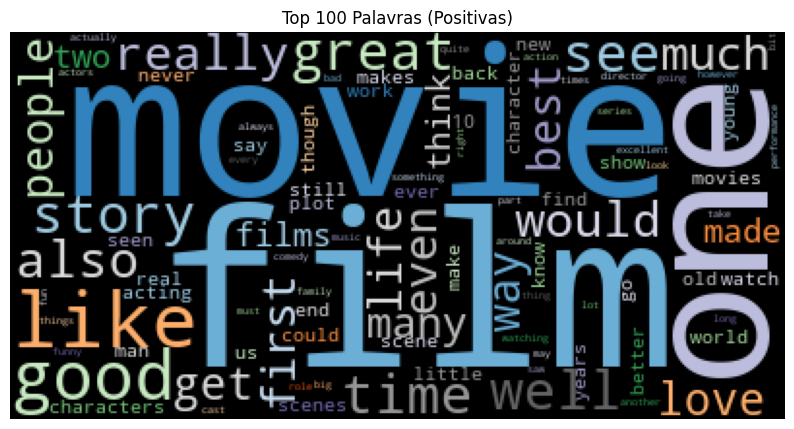

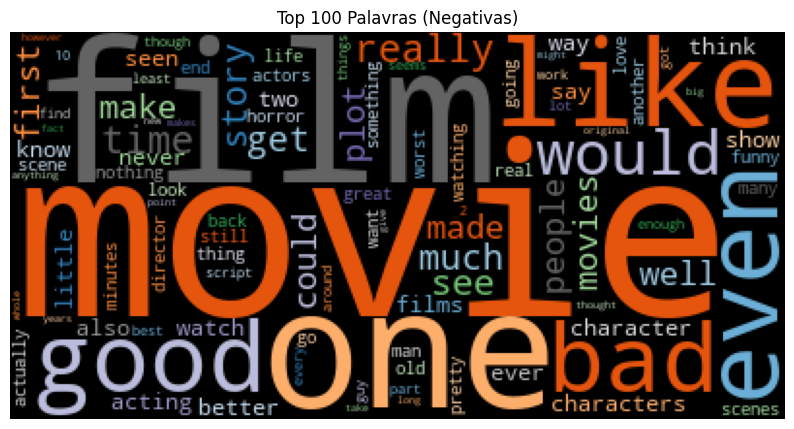

In [95]:
for word in stop_words:
    freq_positivos.pop(word, None)
    freq_negativos.pop(word, None)

get_word_cloud("Top 100 Palavras (Positivas)", 100, freq_positivos)
get_word_cloud("Top 100 Palavras (Negativas)", 100, freq_negativos)


### Passo 4 - Sumário dos dados obtidos através da leitura dos Datasets.
---

O objetivo deste passo é apresentar os resultados obtidos após a leitura do Dataset para começarmos com a implementação da nossa rede neural.

--- 

### Passo 4.1 - Dataset de Reviews do IMDB.

#### 4.1.1 - Tokens de Reviews (Positivos e Negativos)

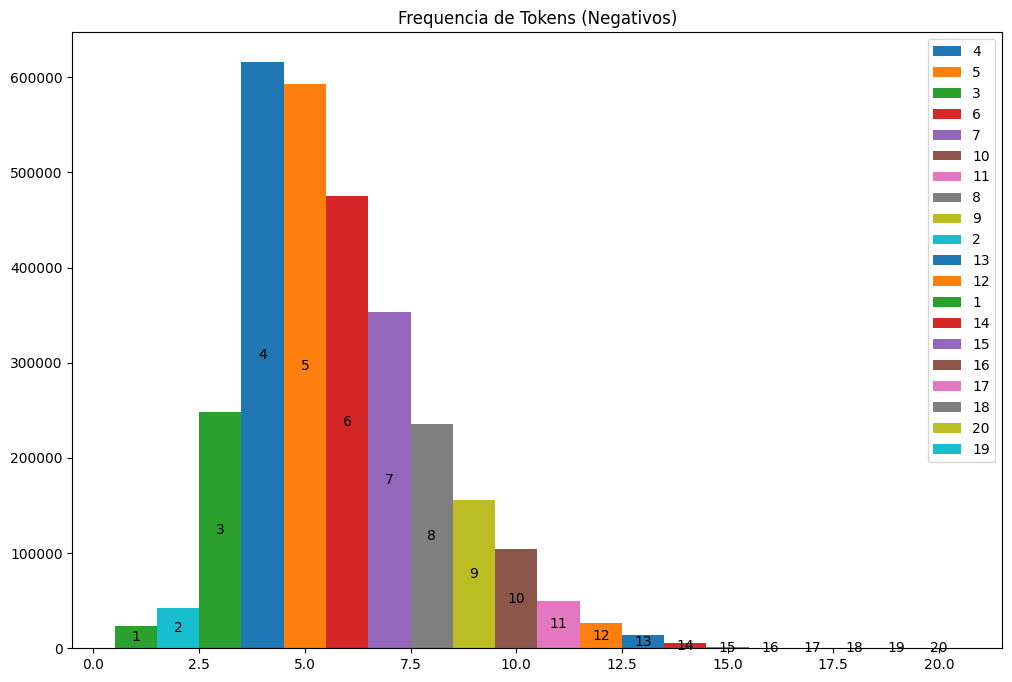

In [96]:

positive_tokens = []
positive_tokens_len = {}
negative_tokens = []
negative_tokens_len = {}

def remove_least(tokens: dict, least: int):
    return {key: value for key, value in tokens.items() if value > least}

for dirpath in diretorios:
    # buscamos os tokens de todos os arquivos de um diretorio
    tokens = get_dir_content(dirpath)
    # verifica em qual array iremos inserir os tokens
    if ('positivos' in dirpath): positive_tokens += tokens 
    else: negative_tokens += tokens 

# vamos contabilizar cada token pelo seu tamanho
for token in positive_tokens:
    tamanho = len(token)

    if (tamanho in positive_tokens_len.keys()): 
        positive_tokens_len[tamanho] += 1
    else: positive_tokens_len[tamanho] = 1 

for token in negative_tokens:
    tamanho = len(token)

    if (tamanho in negative_tokens_len.keys()): 
        negative_tokens_len[tamanho] += 1
    else: negative_tokens_len[tamanho] = 1

positive_tokens_len = remove_least(positive_tokens_len, 15)
negative_tokens_len = remove_least(negative_tokens_len, 15)

# print(positive_tokens_len)
# print(negative_tokens_len)

width = 1
fig, ax = plt.subplots(figsize=(12, 8))
bottom = [0] * len(negative_tokens_len)

for size, count in negative_tokens_len.items():
    bar = ax.bar(size, count, width, label=size)
    ax.bar_label(bar, labels=[size], label_type='center')


ax.set_title('Frequencia de Tokens (Negativos)')
ax.legend()

plt.show()

